-------------------------------------
> ***Name:*** Mubanga Nsofu <br>
> ***Learner Id:*** 149050 <br>
> ***Course:*** BAN6800 (Business Analytics Capstone) <br>
> ***Assignment Four:*** Business Analytics Model <br>
> ***Lecturer:*** Professor Raphael Wanjiku <br>
> ***Institution:*** Nexford University <br>
> ***Date:*** 30th May 2025

-------------------------------------------
> ***INTRODUCTION*** <br>

> This notebook implements a supervised learning model, to help Takealot predict customer online purchasing Intent. This will ultimately help Takealot compete better in South Africa. <br/>The code below implements a supervised Learning Pipeline, from the realm of classification, for Customer online purchasing intent for Takealot


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, make_pipeline
import optuna
import shap
import joblib

------------------
***LOAD DATASET FROM MILESTONE ONE***

In [2]:
data_frame = pd.read_csv('online_shoppers_Intention_cleaned.csv')

In [3]:
data_frame

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,VisitorType_Other,VisitorType_Returning_Visitor,Total_Duration,Interaction_Intensity
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,-1.233426,-0.790293,-0.894178,-0.762629,-0.550552,0,-0.083316,0.410621,-0.642894,-0.113505
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,-0.136078,-0.207952,-0.894178,-0.514182,-0.550552,0,-0.083316,0.410621,-0.611486,-0.113505
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,2.058618,-0.790293,2.437081,-0.265735,-0.550552,0,-0.083316,0.410621,-0.642894,-0.113505
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,0.961270,-0.207952,-0.477771,-0.017289,-0.550552,0,-0.083316,0.410621,-0.641585,-0.113505
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,0.961270,0.374389,-0.894178,-0.017289,1.816360,0,-0.083316,0.410621,-0.334952,-0.113505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822,-0.310366,-0.288966,0.342125,-0.308821,...,2.058618,2.121412,-0.894178,-0.762629,1.816360,0,-0.083316,0.410621,0.303651,-0.040118
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957,-0.457683,-0.447364,-0.317178,-0.308821,...,0.961270,-0.207952,-0.894178,0.976499,1.816360,0,-0.083316,0.410621,-0.414330,-0.113505
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063,1.261014,0.897093,-0.317178,-0.308821,...,0.961270,-0.207952,-0.894178,2.218733,1.816360,0,-0.083316,0.410621,-0.552474,-0.113505
12328,0.507228,-0.032916,-0.396478,-0.244931,-0.376210,-0.443536,-0.457683,-0.453140,-0.317178,-0.308821,...,-0.136078,-0.207952,-0.061364,1.721839,-0.550552,0,-0.083316,0.410621,-0.436290,-0.113505


----------------------
***SPLIT FEATURES AND TARGET***

In [4]:
X = data_frame.drop(columns=["Revenue"])
y = data_frame["Revenue"].astype(int)

------------
***APPLY SMOTE FOR CLASS BALANCING***

Synthetic Mionroty Over-sampling technique (SMOTE) generates sythetic instances of the minority class and helps to balance the class (Tamanna, 2023). <br/> Google (2024) demonstrate in their tutorial how to classify highly imbalanced data.

In [5]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

-----------------
***SPLIT TRAIN AND TEST SETS***

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

------------------
***LOGISTIC REGRESSION MODEL IMPLEMENTATION WITH STRATIFIED CROSS VALDIATION AND TUNING WITH OPTUNA***

In [7]:
def objective_logreg(trial):
    C = trial.suggest_float("C", 0.001, 10.0, log=True)
    # Use only 'l2' since 'lbfgs' supports it
    model = make_pipeline(
        LogisticRegression(
            C=C,
            penalty="l2",  # Fixed
            class_weight='balanced',
            solver='lbfgs',
            max_iter=500,
            random_state=42
        )
    )
    score = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1).mean()
    return score

study_logreg = optuna.create_study(direction='maximize')
study_logreg.optimize(objective_logreg, n_trials=30)


[I 2025-06-01 05:40:51,816] A new study created in memory with name: no-name-a2e30d77-3869-49ea-a129-536031c23f38
[I 2025-06-01 05:40:55,957] Trial 0 finished with value: 0.9046247887776516 and parameters: {'C': 0.0064197873801653165}. Best is trial 0 with value: 0.9046247887776516.
[I 2025-06-01 05:40:57,638] Trial 1 finished with value: 0.9098517814552768 and parameters: {'C': 0.1147701805982739}. Best is trial 1 with value: 0.9098517814552768.
[I 2025-06-01 05:40:57,744] Trial 2 finished with value: 0.910253156767031 and parameters: {'C': 0.8044884824080477}. Best is trial 2 with value: 0.910253156767031.
[I 2025-06-01 05:40:57,847] Trial 3 finished with value: 0.9072587203061427 and parameters: {'C': 0.01428417947620378}. Best is trial 2 with value: 0.910253156767031.
[I 2025-06-01 05:40:57,958] Trial 4 finished with value: 0.9101980052436225 and parameters: {'C': 0.43234209393455547}. Best is trial 2 with value: 0.910253156767031.
[I 2025-06-01 05:40:58,064] Trial 5 finished with 

In [8]:
print("\nBest parameters for Logistic Regression:", study_logreg.best_params)

# Final model using best parameters
best_logreg_model = make_pipeline(
    LogisticRegression(
        C=study_logreg.best_params['C'],
        penalty='l2',
        class_weight='balanced',
        solver='lbfgs',
        max_iter=500,
        random_state=42
    )
)
best_logreg_model.fit(X_train, y_train)
y_pred_logreg = best_logreg_model.predict(X_test)
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, best_logreg_model.predict_proba(X_test)[:, 1]))




Best parameters for Logistic Regression: {'C': 9.978862418509248}

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      3127
           1       0.87      0.76      0.81      3127

    accuracy                           0.82      6254
   macro avg       0.83      0.82      0.82      6254
weighted avg       0.83      0.82      0.82      6254

Logistic Regression ROC AUC: 0.9001514502416565


---------------------
***XGBoost CLASSIFIER MODEL WITH REGULARIZATION AND ALSO USING OPTUNA FOR HYPERPARAMETER TUNING***

In [9]:
def objective_xgb(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0), # To prevent overfitting
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 10.0) # To prevent overfitting
    }
    model = xgb.XGBClassifier(**param)
    #score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=3, n_jobs=-1)
    score = cross_val_score(model, X_train, y_train, scoring="roc_auc",cv=StratifiedKFold(n_splits=5), n_jobs=-1)
    return score.mean()

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

print("Best Hyperparameters for XGBoost:", study_xgb.best_params)

best_xgb = xgb.XGBClassifier(**study_xgb.best_params, early_stopping_rounds=10, eval_metric="logloss")
best_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = best_xgb.predict(X_test)
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))



[I 2025-06-01 05:41:13,102] A new study created in memory with name: no-name-b20e99e8-0653-4de9-9508-d787a9182520
[I 2025-06-01 05:41:17,098] Trial 0 finished with value: 0.9846009806072399 and parameters: {'max_depth': 10, 'learning_rate': 0.02441331266710499, 'n_estimators': 268, 'subsample': 0.7643256499632299, 'colsample_bytree': 0.6231407075749482, 'reg_alpha': 0.7641369321452124, 'reg_lambda': 7.141528326879618}. Best is trial 0 with value: 0.9846009806072399.
[I 2025-06-01 05:41:18,700] Trial 1 finished with value: 0.9771649204366462 and parameters: {'max_depth': 6, 'learning_rate': 0.020996081339316342, 'n_estimators': 224, 'subsample': 0.745661161567141, 'colsample_bytree': 0.7313825048040117, 'reg_alpha': 0.5926436777023267, 'reg_lambda': 8.264860685671092}. Best is trial 0 with value: 0.9846009806072399.
[I 2025-06-01 05:41:21,802] Trial 2 finished with value: 0.9874847382017314 and parameters: {'max_depth': 8, 'learning_rate': 0.19049333873126478, 'n_estimators': 215, 'subs

Best Hyperparameters for XGBoost: {'max_depth': 9, 'learning_rate': 0.051275316242041395, 'n_estimators': 379, 'subsample': 0.9552089960929482, 'colsample_bytree': 0.7473259463789693, 'reg_alpha': 0.26688595236204243, 'reg_lambda': 5.172756826579817}

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3127
           1       0.94      0.94      0.94      3127

    accuracy                           0.94      6254
   macro avg       0.94      0.94      0.94      6254
weighted avg       0.94      0.94      0.94      6254

XGBoost ROC AUC: 0.9868269277281984


------------------
***COMPARE XGBOOST VERSUS LOGISTIC REGRESSION CLASSIFIER TUNED MODELS FROM THE CLASSIFICATION REPORTS ABOVE***

> XGBoost outperforms the Logistic Regression classifier accross all the metrics: Precision (Class 1), Recall (Class 1),	F1-Score (Class 1)	and ROC AUC <br/>
> Logistic Regression underperforms especially in recall for the positive class (only 75%) <br/>
> XGBoost is the final predictive model to be deployed for predicting purchasing intent

----------------
***EVALUATE OVERFITTING FOR XGBOOST MODEL***

In [10]:
# Evaluate overfitting
print("\nTrain Accuracy:", accuracy_score(y_train, best_xgb.predict(X_train)))
print("Train ROC AUC:", roc_auc_score(y_train, best_xgb.predict_proba(X_train)[:, 1]))

xgb_cv_model = xgb.XGBClassifier(**study_xgb.best_params, eval_metric="logloss", use_label_encoder=False)
cv_scores = cross_val_score(xgb_cv_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
print("\nCross-validated ROC AUC:", cv_scores.mean(), "+/-", cv_scores.std())





Train Accuracy: 0.9877313228238519
Train ROC AUC: 0.9993580437839206


C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder"


Cross-validated ROC AUC: 0.9880967603882403 +/- 0.0017022623690947057


> The model is well-regularised and shows excellent generalization due to early stopping and regularization <br/> High Training Accuracy &ROC AUC shows the model fits the training data very well. <br/> High Cross-validated ROC AUC shows the model generalizes to unseen data <br/> The Small std Dev in Cross Validation AUC shows consistent performance across folds which indicates stability of the model 

-------------
***SHAP EXPLANATION***

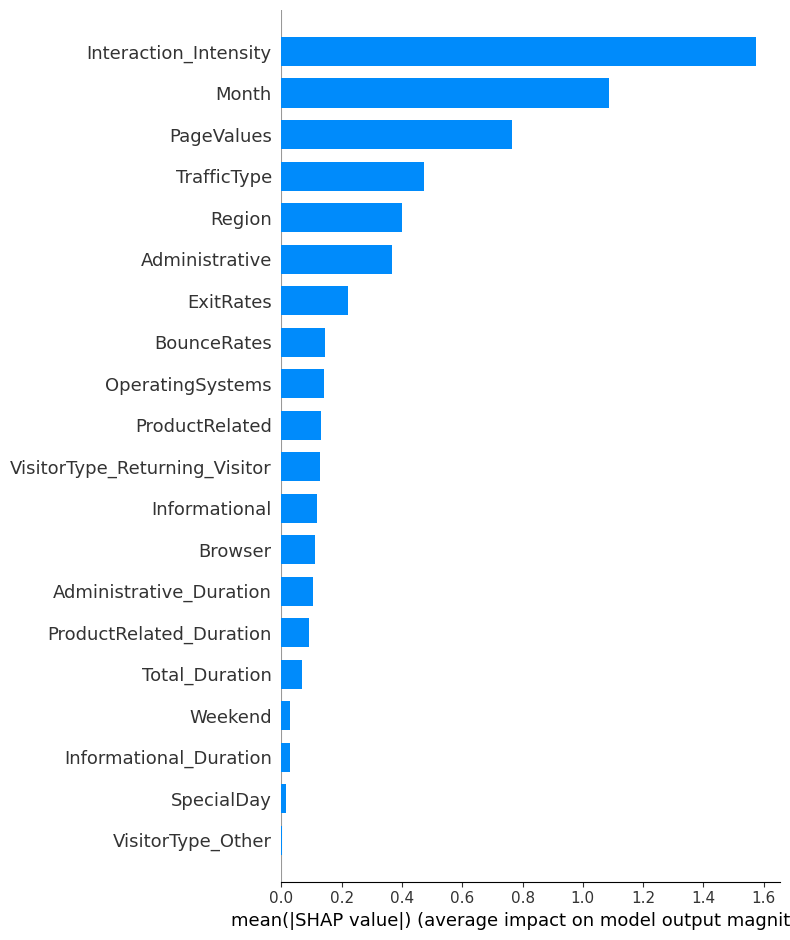

In [11]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

> The SHAP summary plot shows interaction_intensity, Month and PageValues are the top drivers of purchasing intent. <br/>This behavior is typical of e-commerce behavior where high interaction, seasonal influence and product value correlate with higher purchasing likelihood.

-------------------
***ROC CURVE FOR XGBOOST***

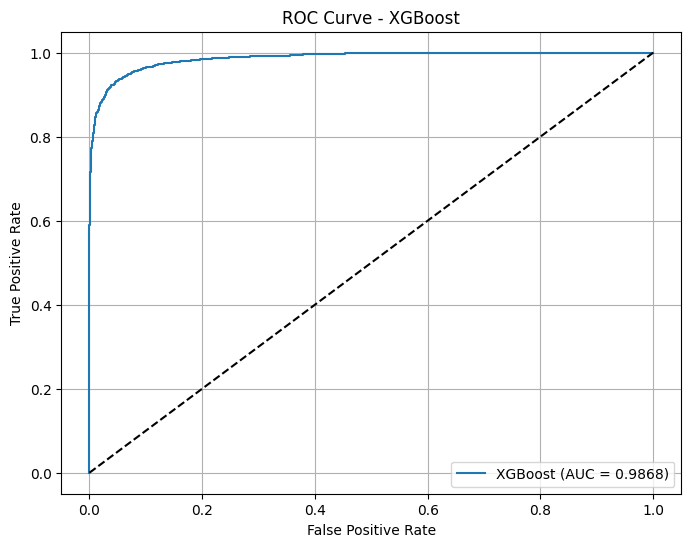

In [12]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]):.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()

> The AUC of ***98.68%*** depicts excellent separation between the classes. <br/>The curve is very close to the top-left corner: this signifies very minimal false positives(predict a customer will purchase and he or she doesnt) and false negatives (predict a customer will not purchase and he or she does infact purchase) 

--------------
***PRECISION RECALL CURVE FOR XGBOOST BEST MODEL***

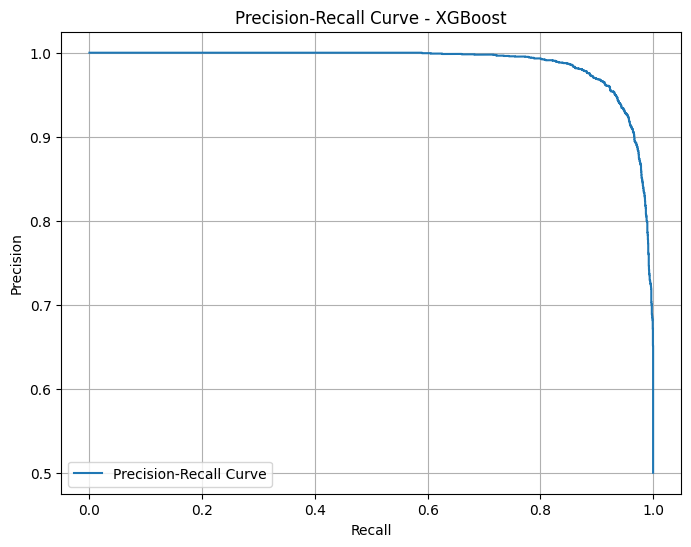

In [13]:
precision, recall, _ = precision_recall_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.grid()
plt.legend()
plt.show()

> The Precision Recall curve stays high (Precision is almost 1) across varions Recall values, which confirms excellent preciosn across most thresholds. <br/>There is an observed steep drop near the end as  recall nears one- this is expected behavior<br/>
> The chart enables Takealot to have confidence as the model has very low false positives and high predictive confidence which is ideal for an imbalanced classification.


------------
***EXPORT THE XGBOOST BEST MODEL***

In [14]:

joblib.dump(best_xgb, "xgboost_model.joblib")

['xgboost_model.joblib']

-------------
***REFERENCES***

> Google. (2024). Classification on imbalanced data. TensorFlow Core. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data <br/>

>Tamanna. (2023). Handling Imbalanced Datasets in Python: Methods and Procedures. Medium. https://medium.com/@tam.tamanna18/handling-imbalanced-datasets-in-python-methods-and-procedures-7376f99794de



